# Tutorial 8: Data Analysis in-class practices
## 8.1 Datetime objects in Pandas
- We may convert a Series of date strings into ```Datetime``` object by using ```pd.to_datetime``` function.


In [1]:
import pandas as pd
date_str = pd.Series(["2020-11-08","2020-11-15","2020-11-22","2020-11-29","2020-12-06"])
date1 = pd.to_datetime(date_str, format="%Y-%m-%d") #convert string into datetime object
print(date1)

0   2020-11-08
1   2020-11-15
2   2020-11-22
3   2020-11-29
4   2020-12-06
dtype: datetime64[ns]


- Series of Datetime objects can be converted to date strings using ```Series.dt.strftime``` method. The argument consists of a string of format codes. \
Selected Format codes are listed as follows:
  * ```%Y```: year in 4 digits
  * ```%m```: month in 2 digits
  * ```%b```: abbreviated month name
  * ```%d```: day in 2 digits
  * ```%a```: abbreviated weekday name
  * ```%A```: full weekday name
  * ```%H```: hour in a day (24-hours system)
  * ```%M```: minute in an hour
  * ```%S```: second in a minute

In [2]:
date_str2 = date1.dt.strftime("%a %d %b %Y")
print(date_str2)

0    Sun 08 Nov 2020
1    Sun 15 Nov 2020
2    Sun 22 Nov 2020
3    Sun 29 Nov 2020
4    Sun 06 Dec 2020
dtype: object


In [3]:
date_str3 = date1.dt.strftime("%d/%m/%Y %H:%M")
print(date_str3)

0    08/11/2020 00:00
1    15/11/2020 00:00
2    22/11/2020 00:00
3    29/11/2020 00:00
4    06/12/2020 00:00
dtype: object


## 8.2 Review of post earning annoucement drift from Lecture 9
Please load `crsprets_pead.csv` file for the dataset used in Lecture 9, which can be download from the dropbox link on Lecture 9 notebook file. 

* ```permno```: firm identifier;
* ```date```: trading date;
* ```prc```: stock price;
* ```mcap```: market capitalization;
* ```ret```: daily stock return;
* ```mkt```: daily return of the market index;
* ```exret```: daily excess stock return (```ret```-```mkt```);
* ```rdq1```: the date on which quarterly earnings per share are first publicly reported;
* ```leadrdq1```: next report date of quarterly earnings per share;
* ```sue3```: standardized unexpected earnings.
  $$
  \text{sue3} = \frac{\text{earnings}_t - \mathbb{E}_{t-1} \big[ \text{earnings}_t \big]}{\text{stock price}_t},
  $$
  where $\mathbb{E}_{t-1} \big[ \text{earnings}_t \big]$ is based on the analyst forecasts.

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

crsprets_pead = pd.read_csv(
    "../data/crsprets_pead.csv", 
    index_col=0
)
crsprets_pead = crsprets_pead[['permno', 'date', 'rdq1', 'exret', 'mcap', 'leadrdq1', 'sue3']] #obtain useful columns

### 8.2.1  Data cleaning for analysing excess return from earning announcement
This part is adopted from Lecture 9, we will construct the weighted average portfolio in the next session with some modification.

* We need to create an indicator to denote the days after announcement (e.g., the first day after the announcement, the second day after the announcement, etc.).
    * We call this indicator event days (which equal 0, 1, 2, ...).   <br>
<br>
* On each event day, we sort the stocks based on their unexpected earnings (```sue3```).
   * The stocks in the first group have the most postive unexpected earnings, whereas those firms in the last group are the most disappointing firms in terms of unexpected EPS. <br>
<br>
* Finally, for the stocks in each of the five SUE groups on each event day, we compute the value-weighted portfolio return.
    * Suppose that we have $N_t$ stocks at time $t$, with stock returns $R_{i,t}$, in the portfolio.
    * Their market caps are $\text{mcap}_{i,t-1}$ at period $t-1$.
    * The value-weighted portfolio return at time $t$ is
    $$
    \frac{\sum_{i=1}^{N_t} \text{mcap}_{i,t-1} \times R_{i,t}}{\sum_{i=1}^{N_t} \text{mcap}_{i,t-1}}.
    $$

In [7]:
temp = crsprets_pead.sort_values(by=['permno', 'rdq1', 'date'])
temp['lagmcap'] = temp.mcap.shift(1) #create lagged market caps of each firm (one day lag)

#Keep firm-day observations between the current announcement date rdq1 and the next announcement date leadrdq1
temp = temp.loc[(temp.rdq1<=temp.date) & (temp.date<temp.leadrdq1)]

# create event days variable within each firm-event date group (ncount)
temp['ncount'] = temp.groupby(['permno','rdq1']).cumcount() 
temp.head(10)

,permno,date,rdq1,exret,mcap,leadrdq1,sue3,lagmcap,ncount
70730,10104,2010-03-25,2010-03-25,0.013307,1.306971e+08,2010-06-24,0.000406,1.292918e+08,0
77404,10104,2010-03-26,2010-03-25,-0.014119,1.289404e+08,2010-06-24,0.000406,1.306971e+08,1
84078,10104,2010-03-29,2010-03-25,-0.011468,1.283382e+08,2010-06-24,0.000406,1.289404e+08,2
90751,10104,2010-03-30,2010-03-25,-0.001631,1.281876e+08,2010-06-24,0.000406,1.283382e+08,3
97423,10104,2010-03-31,2010-03-25,0.009422,1.290408e+08,2010-06-24,0.000406,1.281876e+08,4
104098,10104,2010-04-01,2010-03-25,-0.018365,1.277861e+08,2010-06-24,0.000406,1.290408e+08,5
110772,10104,2010-04-05,2010-03-25,-0.004834,1.283883e+08,2010-06-24,0.000406,1.277861e+08,6
117444,10104,2010-04-06,2010-03-25,0.007652,1.296431e+08,2010-06-24,0.000406,1.283883e+08,7
124118,10104,2010-04-07,2010-03-25,0.008464,1.300446e+08,2010-06-24,0.000406,1.296431e+08,8
130802,10104,2010-04-08,2010-03-25,-0.005919,1.296431e+08,2010-06-24,0.000406,1.300446e+08,9


### 8.2.2  In-class practice: Generating value weighted portfolios

Repeat the procedures from Lecture 9 notebook file to generate the cumulative abnormal returns plot with respect to event days. Change the following assumptions during the analysis:
* Keep 60 days after earnings announcement days ( `ncount` from 0 to 60)
* Form deciles based on the unexpected earnings (column `sue3`). Therefore, 10 portfolios are formed instead of 5.

In [8]:
#keep first 60 days after earnings announcement dates
temp = temp[temp.ncount <= 60]

# Drop any duplicates in the dataset
peadrets = temp.sort_values(by=['ncount','permno','rdq1']).drop_duplicates()

# Group the data into 10 groups on each trading day, group by ncount, sorted by unexpected earnings (sue3).
# sue3r represents each of 10 formed portfolios, where 0 represents lowest sue3 group and 9 represents highest sue3 group.
peadrets['sue3r'] = peadrets.groupby('ncount', group_keys=False)['sue3'].apply(lambda x: pd.qcut(x, 10, labels=False, duplicates='drop'))

In [9]:
peadrets[peadrets.ncount==1].sort_values(by=['ncount','sue3r'])

,permno,date,rdq1,exret,mcap,leadrdq1,sue3,lagmcap,ncount,sue3r
91055,10104,2015-06-18,2015-06-17,-0.057597,1.866486e+08,2015-09-16,-0.002184,1.961251e+08,1,0
466308,10107,2012-10-19,2012-10-18,-0.013376,2.410475e+08,2013-01-24,-0.001344,2.482435e+08,1,0
213194,10107,2013-07-19,2013-07-18,-0.115489,2.615606e+08,2013-10-24,-0.002605,2.952136e+08,1,0
465998,10107,2014-07-23,2014-07-22,-0.000951,3.697220e+08,2014-10-23,-0.001319,3.693924e+08,1,0
264653,10137,2010-05-06,2010-05-05,0.012301,3.447358e+06,2010-08-04,-0.003913,3.518578e+06,1,0
...,...,...,...,...,...,...,...,...,...,...
47159,93422,2018-03-01,2018-02-28,0.118677,2.301254e+06,2018-04-25,0.125392,2.077153e+06,1,9
303212,93422,2018-07-26,2018-07-25,-0.105825,2.529213e+06,2018-11-07,0.014682,2.833479e+06,1,9
357745,93422,2018-11-08,2018-11-07,-0.061350,2.173070e+06,2019-02-20,0.017182,2.322365e+06,1,9
99122,93436,2016-10-27,2016-10-26,0.012738,3.057926e+07,2017-02-22,0.005538,3.031396e+07,1,9


In [10]:
# Remove the NaNs
peadrets = peadrets.loc[peadrets.sue3r.notna()]
# convert the datatype from float64 to int64
peadrets['sue3r'] = peadrets['sue3r'].astype(np.int64)    

In [11]:
peadrets

,permno,date,rdq1,exret,mcap,leadrdq1,sue3,lagmcap,ncount,sue3r
70730,10104,2010-03-25,2010-03-25,0.013307,1.306971e+08,2010-06-24,0.000406,1.292918e+08,0,4
492303,10104,2010-06-24,2010-06-24,-0.004010,1.116777e+08,2010-09-16,0.002658,1.139897e+08,0,8
380925,10104,2010-09-16,2010-09-16,-0.014013,1.274876e+08,2010-12-16,0.002518,1.293979e+08,0,8
309763,10104,2010-12-16,2010-12-16,-0.013061,1.529368e+08,2011-03-24,0.001849,1.540483e+08,0,7
259686,10104,2011-03-24,2011-03-24,0.014697,1.626450e+08,2011-06-23,0.001216,1.589508e+08,0,6
...,...,...,...,...,...,...,...,...,...,...
463842,93436,2017-07-28,2017-05-03,0.002890,5.591079e+07,2017-08-02,-0.001976,5.580900e+07,60,0
422468,93436,2017-10-26,2017-08-02,-0.000487,5.480211e+07,2017-11-01,0.000940,5.474666e+07,60,6
392127,93436,2018-01-30,2017-11-01,-0.000419,5.837338e+07,2018-02-07,-0.001906,5.899962e+07,60,0
310693,93436,2018-07-27,2018-05-02,-0.023236,5.069683e+07,2018-08-01,0.000789,5.228873e+07,60,5


In [12]:
#weighted average return function applied groupwise, where groups are formed by each event date/ portfolio pair.
def get_port_vw(g):
    g = g.dropna()
    return np.average(a=g.exret, weights=g.lagmcap) #use market capitalization as weights

peadsue3port = peadrets.groupby(['ncount','sue3r'])[['exret','lagmcap']].apply(get_port_vw)
peadsue3port

ncount  sue3r
0       0       -0.015336
        1       -0.011178
        2       -0.008708
        3       -0.002990
        4        0.003132
                   ...   
60      5        0.000925
        6        0.000117
        7        0.000207
        8        0.000444
        9       -0.001001
Length: 610, dtype: float64

In [13]:
#Unstack the weighted return Series to form a DataFrame with sue3r as columns, ncount as rows, similar to pivot table
peadsue3port = peadsue3port.unstack(level="sue3r")
peadsue3port

sue3r,0,1,2,3,4,5,6,7,8,9
ncount,,,,,,,,,,
0,-0.015336,-0.011178,-0.008708,-0.002990,0.003132,0.003616,0.004815,0.005726,0.007162,0.010683
1,-0.015096,-0.011030,-0.003400,-0.003297,-0.000503,0.002912,0.005442,0.005861,0.007514,0.011270
2,-0.001313,-0.000814,-0.000333,-0.000314,-0.000346,-0.000267,0.000805,-0.001446,-0.000590,0.000931
3,-0.000810,0.000072,-0.000691,0.000852,0.001181,-0.000461,0.000954,-0.000945,0.000948,0.000389
4,-0.000035,0.000093,-0.000023,0.000613,0.000933,0.000573,0.000579,0.000691,0.000480,-0.000564
...,...,...,...,...,...,...,...,...,...,...
56,-0.000664,0.000045,-0.000124,-0.000534,-0.000304,-0.000472,-0.000113,-0.000605,0.000676,0.000542
57,0.000227,0.000127,-0.000049,-0.000164,-0.000289,0.000038,0.000363,0.000720,0.000261,-0.000114
58,0.000705,0.000199,-0.000374,-0.000069,-0.000162,-0.000021,0.001070,0.000159,0.000374,0.000356


In [14]:
# Set portfolio weighted returns on day 0 to be 0
peadsue3port.loc[0,:] = 0
# Remme the DataFrame columns, where sue_group1 represents bottom decile and sue_group10 represents top decile
peadsue3port.columns = ['sue_group1', 'sue_group2', 'sue_group3', 'sue_group4', 'sue_group5', 'sue_group6', 'sue_group7',
                       'sue_group8', 'sue_group9', 'sue_group10']
peadsue3port.head(10)

,sue_group1,sue_group2,sue_group3,sue_group4,sue_group5,sue_group6,sue_group7,sue_group8,sue_group9,sue_group10
ncount,,,,,,,,,,
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,-0.015096,-0.011030,-0.003400,-0.003297,-0.000503,0.002912,0.005442,0.005861,0.007514,0.011270
2,-0.001313,-0.000814,-0.000333,-0.000314,-0.000346,-0.000267,0.000805,-0.001446,-0.000590,0.000931
3,-0.000810,0.000072,-0.000691,0.000852,0.001181,-0.000461,0.000954,-0.000945,0.000948,0.000389
4,-0.000035,0.000093,-0.000023,0.000613,0.000933,0.000573,0.000579,0.000691,0.000480,-0.000564
5,-0.000885,0.000264,-0.000358,0.000247,0.000460,0.000037,-0.000271,0.000233,-0.000536,-0.000101
6,-0.000070,-0.000327,0.000193,-0.000183,-0.000060,-0.000297,-0.000132,-0.000132,-0.000514,-0.000263
7,0.000922,-0.000378,0.000398,0.000188,0.000237,-0.000181,0.000168,0.000319,-0.000200,0.000715
8,-0.001133,-0.000131,0.000483,0.000595,0.000505,0.000037,0.000159,-0.000311,0.000881,-0.000488


In [15]:
#compute cumulative returns for each portfolio formed by sue3
peadsue4port = peadsue3port.cumsum()
peadsue4port

,sue_group1,sue_group2,sue_group3,sue_group4,sue_group5,sue_group6,sue_group7,sue_group8,sue_group9,sue_group10
ncount,,,,,,,,,,
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,-0.015096,-0.011030,-0.003400,-0.003297,-0.000503,0.002912,0.005442,0.005861,0.007514,0.011270
2,-0.016409,-0.011844,-0.003733,-0.003611,-0.000849,0.002645,0.006248,0.004414,0.006924,0.012201
3,-0.017219,-0.011772,-0.004424,-0.002759,0.000333,0.002184,0.007202,0.003469,0.007872,0.012591
4,-0.017254,-0.011679,-0.004447,-0.002146,0.001266,0.002757,0.007781,0.004161,0.008352,0.012026
...,...,...,...,...,...,...,...,...,...,...
56,-0.020974,-0.019060,-0.002168,0.002353,0.008962,0.005720,0.014603,0.007293,0.006182,0.025016
57,-0.020747,-0.018933,-0.002218,0.002189,0.008674,0.005758,0.014966,0.008014,0.006443,0.024902
58,-0.020042,-0.018734,-0.002592,0.002120,0.008511,0.005737,0.016036,0.008172,0.006817,0.025258


In [16]:
ncount = peadsue4port.index #event date index from 0 to 60
ncount

Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59, 60],
      dtype='int64', name='ncount')

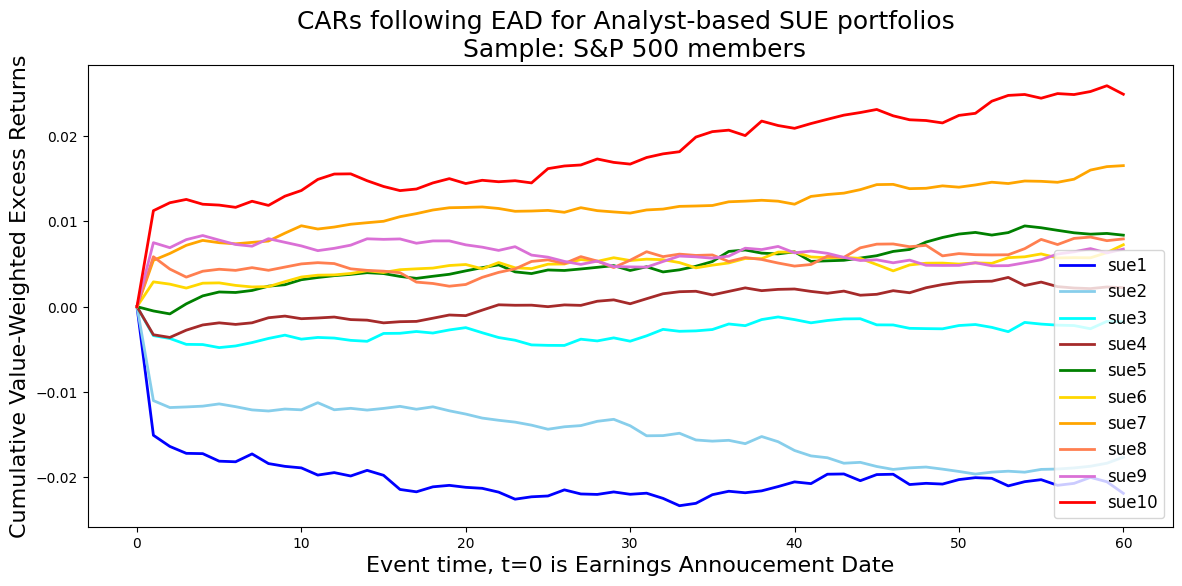

In [17]:
#Plot cumulative abnormal returns in each of 10 portfolios against event date
plt.figure(figsize=(14, 6))
plt.title('CARs following EAD for Analyst-based SUE portfolios \n Sample: S&P 500 members', fontsize=18)
plt.xlabel('Event time, t=0 is Earnings Annoucement Date', fontsize=16)
plt.ylabel('Cumulative Value-Weighted Excess Returns', fontsize=16)

plt.plot(ncount, 'sue_group1', data=peadsue4port, color='blue', linewidth=2, label="sue1") #lowest SUE
plt.plot(ncount, 'sue_group2', data=peadsue4port, color='skyblue', linewidth=2, label="sue2")
plt.plot(ncount, 'sue_group3', data=peadsue4port, color='cyan', linewidth=2, label="sue3")
plt.plot(ncount, 'sue_group4', data=peadsue4port, color='brown', linewidth=2, label="sue4")
plt.plot(ncount, 'sue_group5', data=peadsue4port, color='green', linewidth=2, label="sue5")
plt.plot(ncount, 'sue_group6', data=peadsue4port, color='gold', linewidth=2, label="sue6")
plt.plot(ncount, 'sue_group7', data=peadsue4port, color='orange', linewidth=2, label="sue7")
plt.plot(ncount, 'sue_group8', data=peadsue4port, color='coral', linewidth=2, label="sue8")
plt.plot(ncount, 'sue_group9', data=peadsue4port, color='orchid', linewidth=2, label="sue9")
plt.plot(ncount, 'sue_group10', data=peadsue4port, color='red', linewidth=2, label="sue10") #highest SUE
plt.legend(loc="best", fontsize=12)

## 8.3 WRDS Class account
You may create a WRDS account from [WRDS registration page](https://wrds-www.wharton.upenn.edu/register/), which allow accessing the WRDS database with comprehensive market data, available for download. Dr. Huang will introduce the WRDS database in Lecture 11.
Please note the following when filling the registration form:
* Set up your own username and password, following the provided instructions.
* Select "University of Hong Kong" from Subscriber dropdown list.
* Select "Class - Student With Code" from User Type dropdown list.
* Type `25aae874` in Class Code input box.

The account created is associated with our course. It will be activated after around 3 business days.

If you plan to use WRDS in other courses before graduation, then you may also create a personal account, where you should select "Students (Masters / Undergrad)"  from User Type dropdown list. In this case, you are not required to enter class code.